## DE analysis of TRA genes 

In [1]:
import os
import sys
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import hdf5plugin

# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [3]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
model_path = os.path.join(repo_path, 'models')
# Define plot and path dirs
results_path = os.path.join(repo_path, 'results')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [4]:
# Formatting
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')


In [5]:
# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
from plotting.utils import plot_grouped_boxplot, calc_figsize

In [6]:
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

## Load adata

In [7]:
# Load adata
object_version = 'v5_2025-04-03'
adata = ad.read_h5ad(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_{object_version}.zarr')
# Add final annotations to adata and remove non-annotated cells
ct_anno = pd.read_csv(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_v5_2025-10-15_curatedAnno_v11.csv', index_col = 0)

for c in ct_anno.columns:
    if c in adata.obs.columns:
        adata.obs.drop(c, axis = 1, inplace = True)
adata.obs = adata.obs.join(ct_anno)

adata = adata[~adata.obs['taa_l5'].isnull(),].copy()
# Update metadata
latest_meta_path = get_latest_version(dir = f'{general_data_path}/metadata', file_prefix='Thymus_ageing_metadata')
latest_meta = pd.read_excel(latest_meta_path)

update_obs(adata, latest_meta, on = 'index')


Latest file: Thymus_ageing_metadata_v28_2025-03-13.xlsx
No columns specified to update. Automatically determining columns to update...
Updating columns: ['age', 'age_cont', 'age_group', 'age_group2', 'age_months', 'age_num', 'age_unit', 'chemistry_detail', 'chemistry_orig', 'chemistry_simple', 'cite', 'comment', 'donor', 'health_status', 'in_HTSA', 'library', 'library_bcr', 'library_tcr_ab', 'library_tcr_gd', 'origin_institute', 'path_bcr', 'path_cellbender_gex', 'path_cellranger_arc', 'path_raw_gex', 'path_tcr_ab', 'path_tcr_gd', 'public_data', 'research_no', 'sample', 'sex', 'sort', 'sort_type', 'starsolo_version', 'study', 'type']
On columns: index


## Load DE results

In [8]:
## Load all DE results level 4 (adult vs infant)
import pickle as pkl
with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l4_adult_vs_infant_ageEffect.pkl', 'rb') as f:
    de_ad2inf_lev4_dict = pkl.load(f)

de_ad2inf_lev4 = pd.concat([v for k,v in de_ad2inf_lev4_dict.items()], keys = de_ad2inf_lev4_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})
## Load DE results for priming (adult vs infant)
with open(f'{results_path}/thyAgeing_TEC_dea_4cnts_TECpri_annos.pkl', 'rb') as de_pri:
    de_res_dict_pri = pkl.load(de_pri)
    
de_df_pri = pd.concat([v for k,v in de_res_dict_pri['de_df'].items() if k in ['cTEC-pri:adult-vs-infant', 'unpri:adult-vs-infant',
                                                    'mTEC-pri:adult-vs-infant']], 
           keys = ['cTEC-pri:adult-vs-infant', 'unpri:adult-vs-infant','mTEC-pri:adult-vs-infant'], 
           names = ['cell_type:cont']).reset_index().rename(columns = {'level_1':'gene_name'})
de_df_pri[['cell_type', 'cont']] = de_df_pri['cell_type:cont'].str.split(':', expand = True)
de_ad2inf_lev4_pri = pd.concat([de_ad2inf_lev4, de_df_pri])

de_ad2inf_lev4_pri['contrast'] = 'adult-vs-infant'
de_ad2inf_lev4_pri['change'] = de_ad2inf_lev4_pri.apply(lambda x: 'sign_up' if (x['padj'] <0.05) & (x['log2FoldChange'] >0) else
                               'sign_dw' if (x['padj'] <0.05) & (x['log2FoldChange'] < 0) else
                                'non_sign', axis = 1)

In [9]:
## Load all DE results level 3 (adult vs infant)
with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l3_adult_vs_infant_ageEffect.pkl', 'rb') as f:
    de_ad2inf_lev3_dict = pkl.load(f)

de_ad2inf_lev3 = pd.concat([v for k,v in de_ad2inf_lev3_dict.items()], keys = de_ad2inf_lev3_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})


with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l3_paed_vs_infant_ageEffect.pkl', 'rb') as f:
    de_paed2inf_lev3_dict = pkl.load(f)

de_paed2inf_lev3 = pd.concat([v for k,v in de_paed2inf_lev3_dict.items()], keys = de_paed2inf_lev3_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})


In [10]:
for df in [de_ad2inf_lev4, de_ad2inf_lev3, de_paed2inf_lev3, de_df_pri]:
    df['change'] = df.apply(lambda x: 'sign_up' if (x['padj'] <0.05) & (x['log2FoldChange'] >0) else
                               'sign_dw' if (x['padj'] <0.05) & (x['log2FoldChange'] < 0) else
                                'non_sign', axis = 1)

In [11]:
de_ad2inf_lev3

,cell_type,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,change
0,B_GC-like,LINC01409,1.576464,0.546804,0.490449,1.114905,0.264891,0.536246,non_sign
1,B_GC-like,LINC01128,2.235932,0.182818,0.402442,0.454272,0.649633,0.838361,non_sign
2,B_GC-like,LINC00115,0.458877,-0.244832,0.866254,-0.282633,0.777458,NaN,non_sign
3,B_GC-like,FAM41C,0.391024,0.081756,0.915341,0.089318,0.928829,NaN,non_sign
4,B_GC-like,NOC2L,11.252964,-0.051304,0.242613,-0.211464,0.832525,0.931676,non_sign
...,...,...,...,...,...,...,...,...,...
772901,pDC,MT-CYB,326.376239,0.525054,0.255911,2.051708,0.040198,0.278970,non_sign
772902,pDC,MAFIP,0.512790,1.243672,1.155821,1.076007,0.281924,NaN,non_sign
772903,pDC,AL592183.1,0.475964,0.573267,0.695009,0.824835,0.409465,NaN,non_sign
772904,pDC,AC240274.1,0.530325,-0.002013,1.014820,-0.001984,0.998417,NaN,non_sign


In [12]:
de_ad2inf_lev4['contrast'] = 'adult-vs-infant'
de_ad2inf_lev3['contrast'] = 'adult-vs-infant'
de_paed2inf_lev3['contrast'] = 'paed-vs-infant'

In [41]:
tec_pri_levels = ['cTECIII','cTECII','cTECI', 'cTEC-pri', 'unpri', 'mTEC-pri','mTECI', 'mTECII', 'mTECIII']
tec_levels = ['cTEC', 'mcTEC','mTECI', 'mTECII', 'mTECIII']

In [42]:
tec_lev3 = get_ct_levels(level = 'taa_l3', taa_l1='TEC')
tec_lev4 = get_ct_levels(level = 'taa_l4', taa_l1='TEC')

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


## Load GTEX gene expression across tissues 

In [13]:
gtex_table = pd.read_csv(f'{general_data_path}/tra_analysis/GTEX_log1p_TPM_by_broad_tissue.csv', index_col = 0)

In [17]:
## Tissue specificity scores
def calculate_tau(expr):
    expr_r = expr / max(expr)
    n = len(expr_r)
    tau = np.sum(1 - expr_r) / (n - 1)
    return(tau)

In [18]:
tissue_tau = gtex_table.apply(calculate_tau, axis=1)

In [19]:
gtex_tableT = gtex_table.T.copy()

In [20]:
# get top5 tissue names and values per gene (row)
top5_tissues = gtex_table.apply(lambda r: r.nlargest(5).index.tolist(), axis=1)
top1_tissues = gtex_table.apply(lambda r: r.nlargest(1).index[0], axis=1)


In [24]:
gtex_gene_stats.index.equals(top1_tissues.index)
gtex_gene_stats['top1_tissue'] = top1_tissues
gtex_gene_stats.index.equals(top5_tissues.index)
gtex_gene_stats['top5_tissues'] = top5_tissues

True

True

In [22]:
gtex_gene_stats = pd.read_csv(f'{general_data_path}/tra_analysis/GTEX_expression_stats_by_broad_tissue.csv', index_col = 0)


In [26]:
gtex_gene_stats.to_csv(f'{general_data_path}/tra_analysis/GTEX_expression_stats_by_broad_tissue2.csv', index = True)

## Combine GTEX stats with DE results

In [175]:
de_ad2inf_lev3_tra = pd.merge(de_ad2inf_lev3, gtex_gene_stats, left_on = 'gene_name', right_index = True, how = 'left')
de_ad2inf_lev4_tra = pd.merge(de_ad2inf_lev4, gtex_gene_stats, left_on = 'gene_name', right_index = True, how = 'left')

In [176]:
de_ad2inf_lev3_tra = de_ad2inf_lev3_tra[de_ad2inf_lev3_tra['tissue_tau']>0.8].copy()

In [181]:
de_ad2inf_lev4_tra = de_ad2inf_lev4_tra[de_ad2inf_lev4_tra['tissue_tau']>0.8].copy()

In [182]:
de_ad2inf_lev4_tra.loc[(de_ad2inf_lev4_tra['change'] == 'sign_dw') & (de_ad2inf_lev4_tra['cell_type']=='mTECII')].sort_values('log2FoldChange')

,cell_type,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,change,contrast,gene,tissue_tau,max_expr,top1_tissue,top5_tissues
1024756,mTECII,LGALS7,67.342079,-4.963397,1.375924,-3.607320,0.000309,0.040928,sign_dw,adult-vs-infant,LGALS7,0.937864,5.644347,Skin,"[Skin, Esophagus, Vagina, Minor Salivary Gland..."
1018985,mTECII,KRT72,10.628198,-4.538258,1.284446,-3.533242,0.000410,0.043898,sign_dw,adult-vs-infant,KRT72,0.918185,3.994843,Testis,"[Testis, Skin, Whole Blood, Spleen, Small Inte..."
1025426,mTECII,AVP,51.463567,-4.536806,1.293548,-3.507258,0.000453,0.044413,sign_dw,adult-vs-infant,AVP,0.979580,5.939940,Brain,"[Brain, Testis, Kidney, Adipose, Adrenal Gland]"
1013266,mTECII,GSTA2,8.251209,-4.265693,1.171575,-3.640991,0.000272,0.038649,sign_dw,adult-vs-infant,GSTA2,0.857588,4.717570,Pancreas,"[Pancreas, Liver, Testis, Kidney, Small Intest..."
1014303,mTECII,GNGT1,11.829114,-3.665557,0.892836,-4.105523,0.000040,0.016094,sign_dw,adult-vs-infant,GNGT1,0.925085,0.131440,Ovary,"[Ovary, Testis, Kidney, Bladder, Adipose]"
1024184,mTECII,TUBB4A,16.328271,-3.305298,0.805719,-4.102294,0.000041,0.016094,sign_dw,adult-vs-infant,TUBB4A,0.849282,6.897456,Brain,"[Brain, Adrenal Gland, Testis, Nerve, Spleen]"
1014308,mTECII,AC003092.1,10.492184,-3.273068,0.893215,-3.664369,0.000248,0.038035,sign_dw,adult-vs-infant,AC003092.1,0.968885,0.022217,Testis,"[Testis, Kidney, Adipose, Adrenal Gland, Artery]"
1023591,mTECII,PDE6G,8.804029,-3.148013,0.759442,-4.145164,0.000034,0.016094,sign_dw,adult-vs-infant,PDE6G,0.827722,2.254078,Spleen,"[Spleen, Whole Blood, Testis, Kidney, Small In..."
1013407,mTECII,CASC6,9.402860,-2.850216,0.752332,-3.788508,0.000152,0.032668,sign_dw,adult-vs-infant,CASC6,0.981447,0.375639,Brain,"[Brain, Testis, Spleen, Adipose, Adrenal Gland]"
1014987,mTECII,ADAMDEC1,11.337454,-2.045213,0.543114,-3.765713,0.000166,0.032668,sign_dw,adult-vs-infant,ADAMDEC1,0.919850,5.296340,Small Intestine,"[Small Intestine, Colon, Spleen, Adipose, Stom..."


In [183]:
de_ad2inf_lev4_tra.loc[(de_ad2inf_lev4_tra['change'] == 'sign_up') & (de_ad2inf_lev4_tra['cell_type']=='mTECII')].sort_values('log2FoldChange')

,cell_type,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,change,contrast,gene,tissue_tau,max_expr,top1_tissue,top5_tissues
1025864,mTECII,PHACTR3,18.966889,1.455609,0.354959,4.100780,0.000041,0.016094,sign_up,adult-vs-infant,PHACTR3,0.819867,4.051788,Brain,"[Brain, Pituitary, Lung, Ovary, Spleen]"
1007841,mTECII,CR2,22.215345,4.466993,1.208600,3.696005,0.000219,0.035544,sign_up,adult-vs-infant,CR2,0.960799,4.299025,Spleen,"[Spleen, Small Intestine, Testis, Kidney, Whol..."


In [184]:
de_ad2inf_lev4_tra.loc[(de_ad2inf_lev4_tra['change'] == 'sign_up') & (de_ad2inf_lev4_tra['cell_type']=='TEC-neuro')].sort_values('log2FoldChange')

,cell_type,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,change,contrast,gene,tissue_tau,max_expr,top1_tissue,top5_tissues
523099,TEC-neuro,ZNF750,12.552116,1.715946,0.488825,3.510348,4.475209e-04,0.036541,sign_up,adult-vs-infant,ZNF750,0.818933,5.323566,Skin,"[Skin, Esophagus, Vagina, Minor Salivary Gland..."
509972,TEC-neuro,AGBL4,7.095265,1.833740,0.517901,3.540714,3.990458e-04,0.035199,sign_up,adult-vs-infant,AGBL4,0.892633,1.372348,Brain,"[Brain, Pituitary, Testis, Kidney, Thyroid]"
520629,TEC-neuro,NGB,23.838031,2.131152,0.442341,4.817893,1.450822e-06,0.000628,sign_up,adult-vs-infant,NGB,0.933772,4.349746,Brain,"[Brain, Pituitary, Colon, Esophagus, Testis]"
515907,TEC-neuro,VGF,18.802738,2.213126,0.527737,4.193619,2.745390e-05,0.004905,sign_up,adult-vs-infant,VGF,0.915872,4.936393,Pituitary,"[Pituitary, Brain, Pancreas, Testis, Kidney]"
524663,TEC-neuro,MYLK2,5.009630,2.254903,0.562043,4.011973,6.021340e-05,0.009298,sign_up,adult-vs-infant,MYLK2,0.942142,5.534267,Muscle,"[Muscle, Pancreas, Spleen, Brain, Testis]"
522961,TEC-neuro,FOXJ1,4.956451,2.453113,0.676558,3.625874,2.879856e-04,0.028043,sign_up,adult-vs-infant,FOXJ1,0.855828,3.765813,Testis,"[Testis, Fallopian Tube, Lung, Kidney, Brain]"
514471,TEC-neuro,SNCB,10.655183,2.634045,0.617194,4.267776,1.974316e-05,0.004186,sign_up,adult-vs-infant,SNCB,0.953121,6.615047,Brain,"[Brain, Pituitary, Colon, Testis, Heart]"
513772,TEC-neuro,SLC6A3,3.056128,2.640794,0.757453,3.486412,4.895458e-04,0.038768,sign_up,adult-vs-infant,SLC6A3,0.919685,3.574310,Brain,"[Brain, Thyroid, Ovary, Cervix, Testis]"
509584,TEC-neuro,FAM131C,5.895533,2.676636,0.669308,3.999106,6.358208e-05,0.009568,sign_up,adult-vs-infant,FAM131C,0.838328,4.665390,Brain,"[Brain, Kidney, Pituitary, Adrenal Gland, Heart]"
518704,TEC-neuro,GAL,158.766728,3.040503,0.884320,3.438238,5.855125e-04,0.044069,sign_up,adult-vs-infant,GAL,0.893213,6.361815,Pituitary,"[Pituitary, Brain, Colon, Esophagus, Skin]"


In [185]:
de_ad2inf_lev4_tra.loc[(de_ad2inf_lev4_tra['change'] == 'sign_dw') & (de_ad2inf_lev4_tra['cell_type']=='TEC-neuro')].sort_values('log2FoldChange')

,cell_type,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,change,contrast,gene,tissue_tau,max_expr,top1_tissue,top5_tissues
523569,TEC-neuro,CCL25,74.929551,-8.417208,1.432705,-5.875046,4.227265e-09,0.000009,sign_dw,adult-vs-infant,CCL25,0.978828,4.026185,Small Intestine,"[Small Intestine, Testis, Spleen, Nerve, Brain]"
515577,TEC-neuro,PPP1R17,20.328064,-1.646711,0.402316,-4.093077,4.256860e-05,0.007311,sign_dw,adult-vs-infant,PPP1R17,0.969914,3.534711,Brain,"[Brain, Testis, Pituitary, Whole Blood, Lung]"
525050,TEC-neuro,KCNJ6,33.410576,-1.126006,0.277799,-4.053309,5.049814e-05,0.008298,sign_dw,adult-vs-infant,KCNJ6,0.964557,2.230578,Brain,"[Brain, Pituitary, Pancreas, Testis, Stomach]"
511882,TEC-neuro,NEUROD1,269.281909,-0.897336,0.185180,-4.845759,1.261284e-06,0.000572,sign_dw,adult-vs-infant,NEUROD1,0.975362,5.728023,Brain,"[Brain, Pancreas, Small Intestine, Pituitary, ..."


In [107]:
de_ad2inf_lev4_tra.loc[(de_ad2inf_lev4_tra['change'] == 'sign_up') & (de_ad2inf_lev4_tra['cell_type']=='TEC-cilliated'), 'gene_name'].value_counts()

gene_name
CHRNA9      1
SPATA18     1
HIST1H1E    1
LRP11       1
CFAP69      1
KCNH2       1
BSPRY       1
GALNT18     1
CHPT1       1
GPX2        1
YPEL3       1
MAPK3       1
PPP1R27     1
ATF5        1
PLXNB2      1
TIMP1       1
TCEAL2      1
Name: count, dtype: int64

In [106]:
de_ad2inf_lev4_tra.loc[(de_ad2inf_lev4_tra['change'] == 'sign_up') & (de_ad2inf_lev4_tra['cell_type']=='TEC-neuro') & (de_ad2inf_lev4_tra['tissue_tau']>0.8), 'gene_name'].tolist()

['FAM131C',
 'AGBL4',
 'MYBPHL',
 'SPRR2F',
 'SLC6A3',
 'SNCB',
 'VGF',
 'NAT16',
 'BARX1',
 'GAL',
 'NGB',
 'ODF3L1',
 'FOXJ1',
 'ZNF750',
 'MYLK2',
 'SLC32A1',
 'PHACTR3',
 'DGKK']

In [72]:
# Violin plot of tissue_tau by cell type, split by DE change group
df_v = de_ad2inf_lev4_tra.loc[
    de_ad2inf_lev4_tra['change'].isin(['non_sign', 'sign_up', 'sign_dw']),
    ['cell_type', 'change', 'tissue_tau']
].dropna(subset=['tissue_tau']).copy()

# order cell types by median tissue_tau for nicer layout
order = df_v.groupby('cell_type')['tissue_tau'].median().sort_values(ascending=False).index.tolist()
tec_order = [i for i in order if 'TEC' in i]


In [44]:
# Violin plot of tissue_tau by cell type, split by DE change group
df_v3 = de_ad2inf_lev3_tra.loc[
    de_ad2inf_lev3_tra['change'].isin(['non_sign', 'sign_up', 'sign_dw']),
    ['cell_type', 'change', 'tissue_tau']
].dropna(subset=['tissue_tau']).copy()

# order cell types by median tissue_tau for nicer layout
order_v3 = df_v3.groupby('cell_type')['tissue_tau'].median().sort_values(ascending=False).index.tolist()
tec_order_v3 = [i for i in order_v3 if 'TEC' in i]


<Figure size 320x120 with 0 Axes>

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, '')]

Text(0.5, 0, '')

Text(0, 0.5, 'Count')

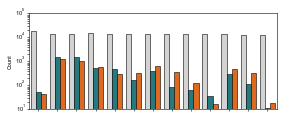

In [74]:
plt.figure(figsize=(4,1.5))

ax_counts = sns.countplot(
    data=df_v[df_v['cell_type'].isin(tec_order)],
    x='cell_type',
    hue='change',
    order=tec_order,
    palette={'non_sign':'lightgray','sign_up':thyAgeing_colors['orange'],'sign_dw':thyAgeing_colors['teal']}
)
ax_counts.set_xticklabels([])     # hide x tick labels on the small top plot
ax_counts.set_xlabel('')
ax_counts.set_ylabel('Count')
ax_counts.set_yscale('log')
leg = ax_counts.get_legend()
if leg:
    leg.remove() 
plt.savefig(f'{plot_path}/tissue_count_by_celltype_change_TEC_lev3_{today}.pdf', bbox_inches='tight')
plt.show()

<Figure size 320x160 with 0 Axes>

/tmp/ipykernel_1658192/3266775203.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax_counts = sns.violinplot(


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'mTECII'),
  Text(1, 0, 'mTECI'),
  Text(2, 0, 'mcTEC'),
  Text(3, 0, 'mTECIII'),
  Text(4, 0, 'TEC-EMT'),
  Text(5, 0, 'mTECI-trans'),
  Text(6, 0, 'TEC-myo'),
  Text(7, 0, 'cTECII'),
  Text(8, 0, 'TEC-neuro'),
  Text(9, 0, 'TEC-cilliated'),
  Text(10, 0, 'cTECI'),
  Text(11, 0, 'cTECIII'),
  Text(12, 0, 'TEC-iono')])

Text(0.5, 0, 'Cell type')

Text(0, 0.5, 'tissue_tau')

Text(0.5, 1.0, 'Distribution of tissue_tau by cell type and DE change (adult vs infant)')

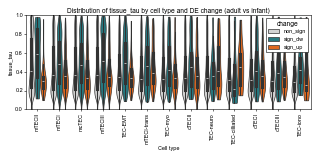

In [ ]:
plt.figure(figsize=(4,2))

ax_counts = sns.violinplot(
    data=df_v[df_v['cell_type'].isin(tec_order)],
    x='cell_type',
    y = 'tissue_tau',
    hue='change',
    order=tec_order,
    cut=0,
    scale='width',
    palette={'non_sign':'lightgray','sign_up':thyAgeing_colors['orange'],'sign_dw':thyAgeing_colors['teal']}
)
plt.xticks(rotation=90)
plt.xlabel('Cell type')
plt.ylabel('tissue_tau')
plt.title('Distribution of tissue_tau by cell type and DE change (adult vs infant)')
plt.legend(title='change', loc='upper right')
plt.tight_layout()
plt.savefig(f'{plot_path}/tissue_tau_by_celltype_change_TEC_lev3_{today}.pdf', bbox_inches='tight')
plt.show()

<Figure size 320x160 with 0 Axes>

/tmp/ipykernel_1658192/2091946874.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


<Axes: xlabel='cell_type', ylabel='tissue_tau'>

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'mTECII'),
  Text(1, 0, 'TEC-mim'),
  Text(2, 0, 'mTECI'),
  Text(3, 0, 'mcTEC'),
  Text(4, 0, 'mTECIII'),
  Text(5, 0, 'cTEC'),
  Text(6, 0, 'TEC-EMT')])

Text(0.5, 0, 'Cell type')

Text(0, 0.5, 'tissue_tau')

Text(0.5, 1.0, 'Distribution of tissue_tau by cell type and DE change (adult vs infant)')

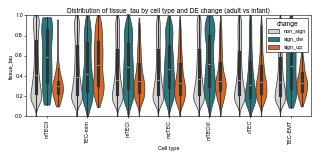

In [46]:

plt.figure(figsize=(4,2))
sns.violinplot(
    data=df_v3[df_v3['cell_type'].isin(tec_order_v3)],
    x='cell_type',
    y='tissue_tau',
    hue='change',
    order=tec_order_v3,
    cut=0,
    scale='width',
    palette={'non_sign':'lightgray','sign_up':thyAgeing_colors['orange'],'sign_dw':thyAgeing_colors['teal']}
)
plt.xticks(rotation=90)
plt.xlabel('Cell type')
plt.ylabel('tissue_tau')
plt.title('Distribution of tissue_tau by cell type and DE change (adult vs infant)')
plt.legend(title='change', loc='upper right')
plt.tight_layout()
plt.savefig(f'{plot_path}/tissue_tau_by_celltype_change_TEC_lev3_{today}.pdf', bbox_inches='tight')
plt.show()